In [23]:
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

import src.data.Dataset as dt

In [24]:
OUTPUT_FILE_PATH = os.path.abspath(
    "./resources/json/md_v4/60_images_0_075_threshold.json"
)
TRAIN_CSV = os.path.abspath("./data/interim/train/20Train.csv")
REPORT_CSV = os.path.abspath("./reports/model_coberture")

with open(OUTPUT_FILE_PATH, "r") as file:
    data = json.load(file)

dataset = dt.load_from_csv(TRAIN_CSV)

report_columns = [
    "file_name",
    "label",
    "threshold",
    "detector_label",
    "false_positive",
    "false_negative",
    "time_inference",
]
report = pd.DataFrame(columns=report_columns)

model = data["info"]["detector"].split(".")[0]
threshold = data["info"]["detector_threshold"]

for image in data["images"]:
    image_file = image["file"]
    indexes = dataset[dataset["file_name"] == image_file]

    if len(indexes) == 1:
        label = int(indexes["label"].iloc[0])
        detector_label = 1 if image["max_detection_conf"] > 0.0 else 0
        false_positive = int(label == 0 and detector_label == 1)
        false_negative = int(label == 1 and detector_label == 0)
        time_inference = image["time_inference"]

        new_row = {
            "file_name": image_file,
            "label": label,
            "threshold": threshold,
            "detector_label": detector_label,
            "false_positive": false_positive,
            "false_negative": false_negative,
            "time_inference": time_inference,
        }
        report = pd.concat([report, pd.DataFrame([new_row])], ignore_index=True)

report_name = f"{len(data['images'])}_images_{model}.csv"
REPORT_CSV = os.path.join(REPORT_CSV, report_name)

dt.dataset_to_csv(report, REPORT_CSV)


The file /Users/carlos/WORKSPACE/MegaClassifier/data/interim/train/20Train.csv has been successfully opened.
The dataset has been successfully saved to /Users/carlos/WORKSPACE/MegaClassifier/reports/model_coberture/60_images_md_v4.csv


In [25]:
positivos_reales = report["label"].sum()
positivos_cubiertos = report[
    (report["label"] == 1) & (report["detector_label"] == 1)
].shape[0]

porcentaje_cubiertos = (
    (positivos_cubiertos / positivos_reales) * 100 if positivos_reales > 0 else 0
)

print(f"Hay {positivos_reales} positivos reales")
print(f"Se detectaron {positivos_cubiertos} positivos")
print(f"El porcentaje de positivos cubiertos es {porcentaje_cubiertos:.2f}%")
print(f"El porcentaje de positivos cubiertos es {porcentaje_cubiertos}")


Hay 28 positivos reales
Se detectaron 28 positivos
El porcentaje de positivos cubiertos es 100.00%
El porcentaje de positivos cubiertos es 100.0


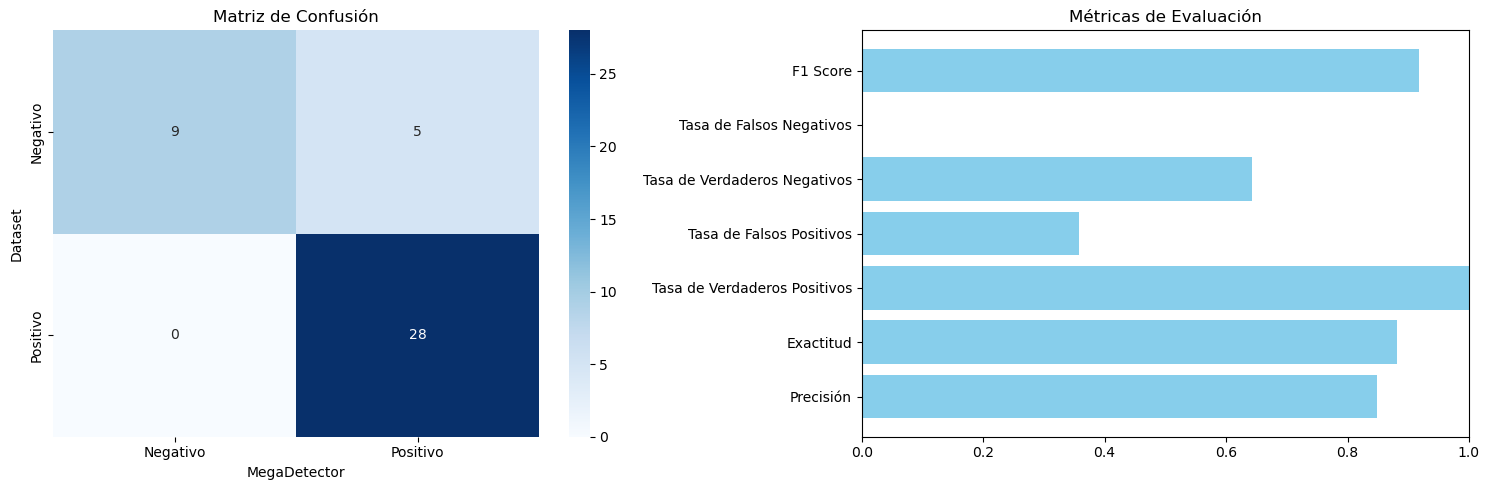

In [26]:
# Calcular métricas
verdaderos_positivos = len(
    report[(report["label"] == 1) & (report["detector_label"] == 1)]
)
falsos_positivos = len(report[(report["label"] == 0) & (report["detector_label"] == 1)])
verdaderos_negativos = len(
    report[(report["label"] == 0) & (report["detector_label"] == 0)]
)
falsos_negativos = len(report[(report["label"] == 1) & (report["detector_label"] == 0)])

precision = (
    verdaderos_positivos / (verdaderos_positivos + falsos_positivos)
    if (verdaderos_positivos + falsos_positivos) > 0
    else 0
)
exactitud = (
    (verdaderos_positivos + verdaderos_negativos) / len(report)
    if len(report) > 0
    else 0
)
tasa_verdaderos_positivos = (
    verdaderos_positivos / (verdaderos_positivos + falsos_negativos)
    if (verdaderos_positivos + falsos_negativos) > 0
    else 0
)
tasa_falsos_positivos = (
    falsos_positivos / (falsos_positivos + verdaderos_negativos)
    if (falsos_positivos + verdaderos_negativos) > 0
    else 0
)
tasa_verdaderos_negativos = (
    verdaderos_negativos / (verdaderos_negativos + falsos_positivos)
    if (verdaderos_negativos + falsos_positivos) > 0
    else 0
)
tasa_falsos_negativos = (
    falsos_negativos / (falsos_negativos + verdaderos_positivos)
    if (falsos_negativos + verdaderos_positivos) > 0
    else 0
)
f1_score = (
    2
    * (precision * tasa_verdaderos_positivos)
    / (precision + tasa_verdaderos_positivos)
    if (precision + tasa_verdaderos_positivos) > 0
    else 0
)

# Crear la matriz de confusión
cm = confusion_matrix(report["label"].astype(int), report["detector_label"].astype(int))

# Crear subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Matriz de confusión
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negativo", "Positivo"],
    yticklabels=["Negativo", "Positivo"],
    ax=axs[0],
)
axs[0].set_xlabel("MegaDetector")
axs[0].set_ylabel("Dataset")
axs[0].set_title("Matriz de Confusión")

# Gráfico de barras para las métricas
metrics = [
    "Precisión",
    "Exactitud",
    "Tasa de Verdaderos Positivos",
    "Tasa de Falsos Positivos",
    "Tasa de Verdaderos Negativos",
    "Tasa de Falsos Negativos",
    "F1 Score",
]
values = [
    precision,
    exactitud,
    tasa_verdaderos_positivos,
    tasa_falsos_positivos,
    tasa_verdaderos_negativos,
    tasa_falsos_negativos,
    f1_score,
]
axs[1].barh(metrics, values, color="skyblue")
axs[1].set_xlim(0, 1)
axs[1].set_title("Métricas de Evaluación")

# Ajustar el layout
plt.tight_layout()
plt.show()
